## Robustness and significance of trends for the recent decades

In [1]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import Markdown as mdp
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import re
import scipy.stats
import statsmodels.api as sm
import sys
import xarray as xr
sys.path.append('../../lib')
from regimeshifts import ews

In [2]:
## Reading values from the significance test output file
ews_recent = pd.read_csv('output/pvalues_1920-today.csv',index_col=0)
## Reading metadata from records with recent data
md_recent = pd.read_csv('output/sel_recent_rec_metadata.csv',index_col=0)

In [3]:
def rec_type(row):
    if '18O' in row.name:
        return 'oxygen'
    elif '13C' in row.name:
        return 'carbon'
    else:
        return 'growth'

In [4]:
coords = pd.DataFrame(index=md_recent.index)
coords['Latitude'] = (md_recent['Northernmost_lat']+md_recent['Southernmost_lat'])/2
coords['Longitude'] = (md_recent['Westernmost_lon']+md_recent['Easternmost_lon'])/2

coords['ar1'] = ews_recent['kc']
coords['pvalue'] = ews_recent['pvalue']
coords['type'] = coords.apply(lambda x: rec_type(x),axis=1)

In [5]:
rec_labels = pd.read_csv('output/sel_rec_labels.csv',index_col=0)

In [6]:
rob_statistics = pd.DataFrame(index=coords.index,columns=['median','perc_positive'])
for i,rec_id in enumerate(rob_statistics.index):
    kc_df = pd.read_csv(f'output/rob_{rec_id}_1920_today.csv', index_col=0)
     ## Filtering out wLs smaller than 30
    kc_df = kc_df[[str(col) for col in kc_df.columns.astype('int') if col>=30]]
    ## Filtering out bWs smaller than 25 years
    kc_df = kc_df[kc_df.index>=25]
    kc_data = kc_df.to_numpy().flatten()
    rob_statistics.loc[rec_id,'median'] = np.median(kc_data)
    rob_statistics.loc[rec_id,'perc_positive'] = len(kc_data[kc_data>0])/len(kc_data)
    rob_statistics.loc[rec_id,'perc_larg035'] = len(kc_data[kc_data>=0.35])/len(kc_data)
sort_by_median = rob_statistics.sort_values(by='median',ascending=False)

In [7]:
### Reading percentage of significant combinations
path = 'output/significant_combinations/'
rob_statistics['perc_signif'] = np.nan
for i,rec_id in enumerate(coords.index):
    bW_vs = np.load(path+f'bW_vs_{rec_id}_recent.npy')
    wL_vs = np.load(path+f'wL_vs_{rec_id}_recent.npy')
    pvals = np.load(path+f'par1_{rec_id}_recent.npy')
    pvals_signif = np.where(pvals<=0.1) ## Significance set to p<=0.1
    kc_df = pd.read_csv(f'output/rob_{rec_id}_1920_today.csv', index_col=0)
    sig_df = pd.DataFrame(data=pvals,index=bW_vs,columns=wL_vs)
    sig_df  = sig_df[sig_df.index>=15]
    perc_sig = np.round(sig_df[sig_df<0.1].count().sum() / sig_df.size,2)
    rob_statistics.loc[rec_id,'perc_signif'] = perc_sig

In [8]:
rob_statistics.to_csv('output/rob_statistics_since_1920_AR1.csv')
coords[['median','perc_positive','perc_larg035','perc_signif']] = rob_statistics
coords.to_csv('output/pvalues_coords_since_1920.csv')

In [9]:
### AR(1) trends on the HadISST dataset
path = 'output/ews_maps/'
hadisst_ews = xr.open_mfdataset(path+'sst_glob_ews_HADISST_1920_2023.nc').load()
hadisst_ews_na =  hadisst_ews.sel(longitude =slice(-57-30,28+4), latitude = slice(42,74+8))

In [10]:
def get_new_coors_proj(grouped_coors_row,coords_df,proj, radius=1.5,init_angle=-20,trim_angle=10,full_angle=220):
    """
    Estimates the new coordinates for a group of records with the same coordinates
    Returns the new coordinates in the coordinate system of the received projection
    """
    res_ang = full_angle - (2 * trim_angle) # 
    n_rec = grouped_coors_row['count'] 
    part_angle = res_ang/(n_rec + 1) # Resulting angle after dividing by the number of records
    group_df = coords_df.loc[grouped_coors_row['record']] ## Retrieving dataframe
    proj_cart = ccrs.PlateCarree() ## Cartesian coordinate system
    x,y = proj.transform_point(group_df.Longitude.mean(),group_df.Latitude.mean(),src_crs=proj_cart)
    ## One degree of latitude in the projection coordinates
    one_deg_lat_proj = y - proj.transform_point(group_df.Longitude.mean(),group_df.Latitude.mean()+1,src_crs=proj_cart)[1]
    group_df['x'] = x
    group_df['y'] = y
    y_plus = []
    x_plus = []    
    
    for i in range(1,n_rec+1):        
        y_plus.append(np.sin(np.deg2rad(init_angle + trim_angle + (i*part_angle))) * one_deg_lat_proj*radius)
        x_plus.append(np.cos(np.deg2rad(init_angle + trim_angle + (i*part_angle))) * one_deg_lat_proj*radius)
    group_df.y += y_plus
    group_df.x += x_plus
    return group_df

In [11]:
def plot_ar1_biv_na(ds,biv_ews,title,namefig,shrink_bar=0.75):
    lons = [-60,30]
    lats = [44,75]
    proj = ccrs.TransverseMercator(central_longitude=lons[0]+(lons[1]-lons[0])/2,
                                   central_latitude=lats[0]+(lats[1]-lats[0])/2)
    n = 20
    aoi = mpath.Path(
        list(zip(np.linspace(lons[0],lons[1], n), np.full(n, lats[1]))) + \
        list(zip(np.full(n, lons[-1]), np.linspace(lats[1], lats[0], n))) + \
        list(zip(np.linspace(lons[1], lons[0], n), np.full(n, lats[0]))) + \
        list(zip(np.full(n, lons[0]), np.linspace(lats[0], lats[1], n)))
    )
    
    fig = plt.figure(figsize=(15,11),facecolor='white')
    ax1 = fig.add_subplot(1, 1, 1, projection=proj)
    #ax2 = fig.add_subplot(1, 2, 2, projection=proj)
    for ax in [ax1]:
        ax.set_boundary(aoi, transform=ccrs.PlateCarree())    
        ax.add_feature(cfeature.LAND,zorder=2)
        ax.coastlines(resolution='50m',zorder=2)
        gl = ax.gridlines(draw_labels=True,linewidth=0.00001, linestyle='--',alpha=0)
        gl.top_labels = False
        gl.right_labels = False
    mapc = ds.ar1.plot(ax=ax1,transform=ccrs.PlateCarree(),vmin=-1,vmax=1,cmap='bwr',add_colorbar=False, rasterized=True)
    #ds.variance.plot(ax=ax2,transform=ccrs.PlateCarree(),vmin=-1,vmax=1,cmap='coolwarm',add_colorbar=False)#,cbar_kwargs={'shrink':0.7})

    cbar = plt.colorbar(mapc, ax=[ax1],pad=0.07,shrink=shrink_bar)
    #ax1.set_title('AR(1)', fontsize=12)
    #ax2.set_title('Variance', fontsize=12)
    cbar.ax.set_ylabel(r'Kendall $\tau$', fontsize=12);
    #fig.suptitle(title,x=0.45,y=0.95,weight='bold');
    
    
    ### Plotting the Kendall values from the bivalve records on top
    ### Grouping coordinates
    coors_yr_df = biv_ews.reset_index()
    coors_yr_df.rename(columns={'index':'record'}, inplace=True)
    coors_yr_gr = coors_yr_df.groupby([coors_yr_df['Latitude'].apply(lambda x: round(x*2)/2),coors_yr_df['Longitude'].apply(lambda x: round(x*2)/2)]).agg(list)
    coors_yr_gr['count'] = coors_yr_gr.record.apply(lambda x: len(x))
    unique_yr_coors = coors_yr_gr[coors_yr_gr['count']==1].record.apply(lambda x: x[0]).values
    yr_unique_coors = biv_ews.loc[unique_yr_coors]
    indicator_label = {'ar1':'AR(1)','var':'Variance'}
    markers = {'growth':'o','oxygen':'^','carbon':'d'}
    markersize = {'growth':100,'oxygen':100,'carbon':115}
    markerlabels = {'Growth':'o',r'$\delta ^{18}O$':'^',r'$\delta ^{13}C$':'d'}
    for indicator,ax in zip(['ar1'],[ax1]):
        ## Records with repeated coordinates
        initial_angles = {(56.5, -6.5):-90,(59.0, 0.5):20,(59.5, 0.5):90,(66.5, -18.0):140,
                          (71.0, 24.0):-145,(47.0, -56.5):50,(60.0, 2.0):-120,(64.5, -23.0):-30}
        full_angles = {(56.5, -6.5):160,(59.0, 0.5):110,(59.5, 0.5):110,(66.5, -18.0):260,
                       (71.0, 24.0):240,(47.0, -56.5):150,(60.0, 2.0):140,(64.5, -23.0):130}
        radii = {(56.5, -6.5):2.5,(59.0, 0.5):5,(59.5, 0.5):3,(66.5, -18.0):2,
                 (71.0, 24.0):2.5,(47.0, -56.5):2.5,(60.0, 2.0):2.3,(64.5, -23.0):2.2}
        origin_radii = {(56.5, -6.5):0,(59.0, 0.5):0.8,(59.5, 0.5):0.7,(66.5, -18.0):0,
                        (71.0, 24.0):0,(47.0, -56.5):0,(60.0, 2.0):0.3,(64.5, -23.0):0}
        ## Parameters for significant records
        plus_radii = {(56.5, -6.5):1.1,(59.0, 0.5):0.7,(66.5, -18.0):2.7,(71.0, 24.0):1.1,(47.0, -56.5):1.2}
        plus_initangle = {(56.5, -6.5):0,(59.0, 0.5):0,(66.5, -18.0):-10,(71.0, 24.0):15,(47.0, -56.5):0}
        for idx,row in coors_yr_gr[coors_yr_gr['count']>1].iterrows():
            new_coors = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx],init_angle=initial_angles[idx],full_angle=full_angles[idx])
            for type_rec,marker in markers.items():
                coors_type = new_coors[new_coors.type==type_rec]
                if len(coors_type) > 0:
                    ax.scatter(x=coors_type.x, y=coors_type.y, s=markersize[type_rec],linewidth=1, marker=marker,
                           c=coors_type[indicator], cmap='bwr',vmin=-1,vmax=1,
                           edgecolors='k',zorder=2)
            ### Adding a star to records with at least 20% of significant trends          
            if len(new_coors[new_coors.perc_signif>=0.2])>0: 
                #signif_rec_id = new_coors[new_coors.pvalue<0.1].index.values
                signif_rec_id = new_coors[new_coors.perc_signif>=0.2].index.values
                new_coors_signif = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx]+plus_radii[idx],init_angle=initial_angles[idx]+plus_initangle[idx],full_angle=full_angles[idx])
                signif_rec = new_coors_signif.loc[[rec for rec in row.record if rec in signif_rec_id]]
                ax.plot(signif_rec.x, signif_rec.y, "*",color='k',markeredgecolor='k', markersize=9)
        
            new_coors_lines = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx]-0.7,init_angle=initial_angles[idx],full_angle=full_angles[idx])
            new_coors_origin = get_new_coors_proj(row,biv_ews,proj,radius=origin_radii[idx],init_angle=initial_angles[idx],full_angle=full_angles[idx])        
            ax.plot([new_coors_lines.x, new_coors_origin.x], [new_coors_lines.y, new_coors_origin.y],color='k')
        ## Records with unique coordinates
        yr_unique_coors = yr_unique_coors.sort_values(by='ar1')
        ax.scatter(x=yr_unique_coors.Longitude, y=yr_unique_coors.Latitude, s=100,linewidth=1.7, 
                   c=yr_unique_coors[indicator], cmap='bwr',vmin=-1,vmax=1,transform=ccrs.PlateCarree(),
                   edgecolors='k',zorder=2)
        ## Records with at least 20% of significant trends
        signif_rec = yr_unique_coors[yr_unique_coors.perc_signif>=0.2]
        signif_rec['offset_lat'] = [1.1,-1,-1,-1]
        signif_rec['offset_lon'] = [-1,-1,-0.6,-1]
        ax.plot(signif_rec.Longitude+signif_rec['offset_lon'], signif_rec.Latitude+signif_rec['offset_lat'],"*",
                color='k',markeredgecolor='k', markersize=9,transform=ccrs.PlateCarree())
        ax.set_extent([ds.longitude.min()+22, ds.longitude.max()-8, ds.latitude.min()+1, ds.latitude.max()-5])
        # Legend
        for label,marker in markerlabels.items():
            ax.plot(-180,0,marker=marker,markersize=9,color='white',markeredgecolor='k',transform=ccrs.PlateCarree(),label=label)
        ax.plot(-180,0,"*",color='k',markeredgecolor='k', markersize=9,transform=ccrs.PlateCarree(),label='p < 0.1')
        ax.legend(loc=(0.05,0.75),frameon=False)
    fig.savefig(f'img/{namefig}.pdf',dpi=300, bbox_inches='tight')

/tmp/ipykernel_11116/3922945797.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_rec['offset_lat'] = [1.1,-1,-1,-1]
/tmp/ipykernel_11116/3922945797.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_rec['offset_lon'] = [-1,-1,-0.6,-1]


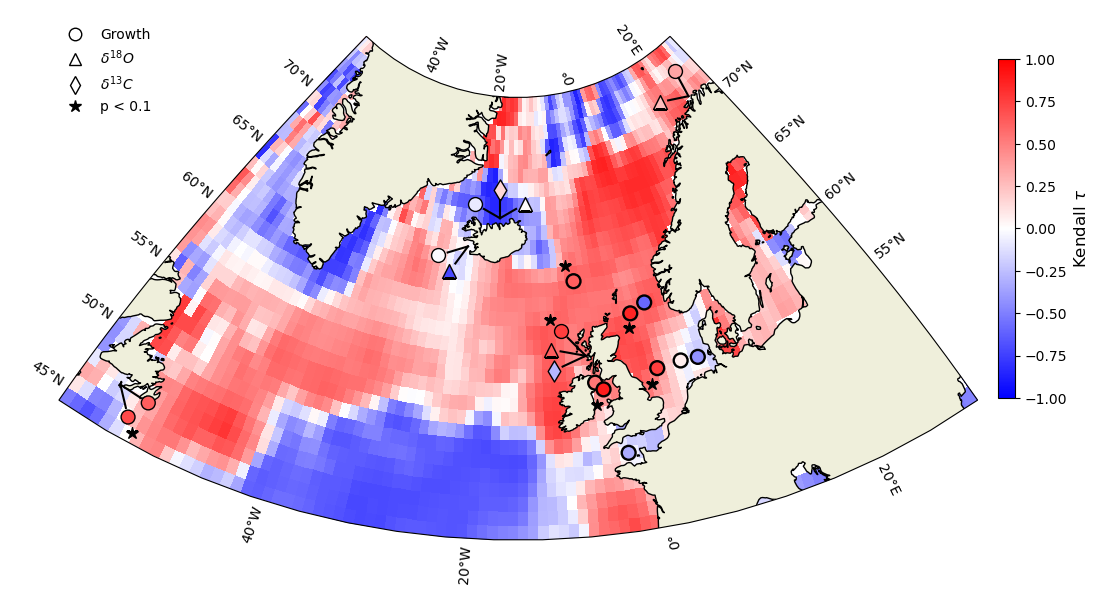

In [12]:
plt.close()
plot_ar1_biv_na(hadisst_ews_na,coords,title='',
                namefig='HADISST_biv_SNA_SST_ar1_all',shrink_bar=0.4)
plt.show()

## Robustness to choice of sliding window size and detrending bandwidth in AR(1)

In [13]:
recs_larg035 = list(rob_statistics[rob_statistics.perc_larg035>=0.5].sort_values(by=['perc_signif','median'],ascending=False).index)
recs_less035 = list(rob_statistics[rob_statistics.perc_larg035<0.5].sort_values(by=['perc_signif','median'],ascending=False).index)
recs_less035[0], recs_less035[1] = recs_less035[1], recs_less035[0]
recs_rob_order = recs_larg035 + recs_less035
recs_rob_order = ['IS_PB_NEars',  'FG_JEM_PAD',  'TP_DR_NEars',  'Faroe_FWB_NEars', 'SPNF_PP_GD',
                  'DB_HH_RCS', 'BS_MM_NE', 'SPNF_deep_PP_NE','BS_MM_d18O','TP_DR_d18O', 'BL_IR', 
                  'NIS_DR_d13C','SWI_MM_HGF','NIS_PB_NEars','NIS_DR_d18O','CNS_BS_LGFraw','TP_DR_d13C',
                  'Norw_HH_RCS','ENS_HH_RCS','EC_SH','SWI_MM_d18O']
#recs_rob_order = list(rob_statistics.sort_values(by=['perc_signif','perc_larg035','median'],ascending=False).index)

In [14]:
def format_label(label):
    if len(label.split('$')) > 1:
        tof_label = label.split('$')[0]
        isot_expr = label.split('$')[1]
        trail = label.split('$')[-1]
    else:
        tof_label = label
    if len(label.split(' ')[-1]) == 1:
        flabel = re.sub(" ", "\n", tof_label,count=len(label.split(' '))-2)
    else:
        flabel = tof_label.replace(' ', '\n')
    if len(label.split('$')) > 1:
        flabel = flabel + '$' + isot_expr + '$' + trail
    return flabel

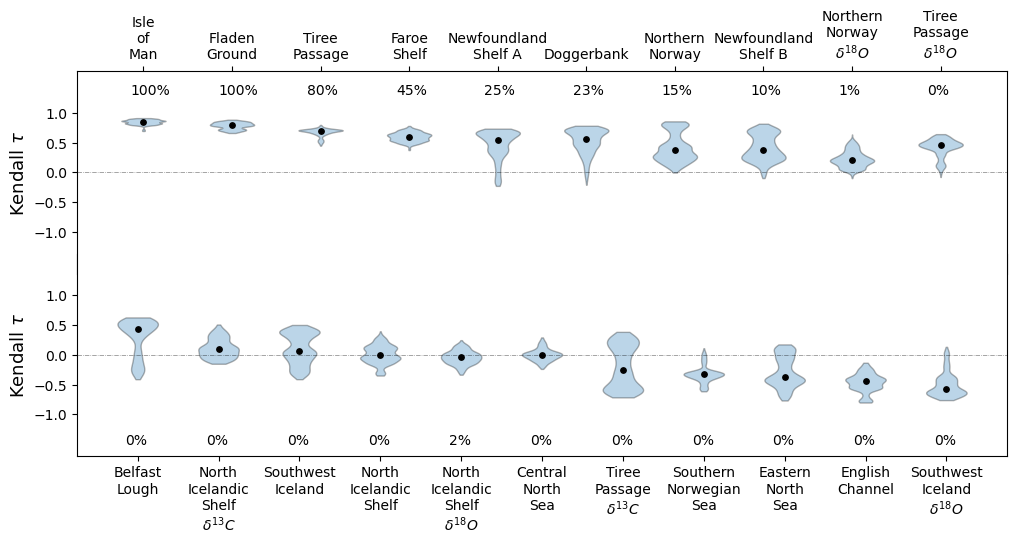

In [15]:
lab_position = ['top','bottom']
fig, axs = plt.subplots(2,1,figsize=(1.1*(len(recs_rob_order)//2) + 1,5),
                        gridspec_kw={'hspace': -0.1},facecolor='white')
for j in [0,1]:
    axs[j].axhline(0,color='k',linestyle='-.',linewidth=0.5,alpha=0.5)
    labels = []
    rob_dist = []
    medians = []
    start = 0 if j==0 else len(recs_rob_order)//2 
    end = -1 if j==1 else len(recs_rob_order)//2 
    if j == 0:
        slice_rec = recs_rob_order[0:len(recs_rob_order)//2 ]
    else:
        slice_rec = recs_rob_order[len(recs_rob_order)//2::]
    for i,rec_id in enumerate(slice_rec):
        color = 'tab:blue'
        kc_df = pd.read_csv(f'output/rob_{rec_id}_1920_today.csv', index_col=0)
         ## Filtering out wLs smaller than 30
        kc_df = kc_df[[str(col) for col in kc_df.columns.astype('int') if col>=30]]
        ## Filtering out bWs smaller than 25 years
        kc_df = kc_df[kc_df.index>=25]
        kc_data = kc_df.to_numpy().flatten()
        rob_dist.append(list(kc_data))
        medians.append(np.median(kc_data))
        label = format_label(rec_labels.loc[rec_id,'label'])
#        if j==0 and i == 4:
#            label = 5*' ' + label
        labels.append(label)
    violin = axs[j].violinplot(rob_dist,showmeans=False, showmedians=False,showextrema=False)    
    inds = np.arange(1, len(medians) + 1)
    axs[j].scatter(inds, medians, marker='o', color='k', s=15, zorder=3)
    for i,pc in enumerate(violin['bodies']):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        loc_perc = -1.5 if j == 1 else 1.3
        perc_signif = str(int(np.round(rob_statistics.loc[slice_rec[i],'perc_signif']*100,0)))
        axs[j].text(i+1-0.15,loc_perc,perc_signif+'%')

    axs[j].set_ylim(-1.7,1.7)
    axs[j].xaxis.set_tick_params(direction='out')
    axs[j].xaxis.set_ticks_position(lab_position[j])
    axs[j].set_xticks(np.arange(1, len(labels) + 1))
    axs[j].set_xticklabels(labels,fontsize=10)
    axs[j].set_xlim(0.25, len(labels) + 0.75)
    axs[j].set_ylabel(r'Kendall $\tau$', fontsize=13)
    axs[j].set_yticks([-1.0,-0.5,0,0.5,1.0])    
    
axs[1].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
fig.savefig(f'img/AR1_rob_biv_rec_since_1920.pdf',dpi=300, bbox_inches='tight')
plt.show()

In [16]:
rob_statistics.to_csv('output/rob_statistics_since_1920.csv')
coords[['median','perc_positive','perc_larg035','perc_signif']] = rob_statistics
coords.to_csv('output/pvalues_coords_since_1920.csv')

### Robustness in trends in lambda

### EN4 dataset

In [17]:
### AR(1) trends on the EN4 dataset
path = 'output/ews_maps/'
en4_ews = xr.open_mfdataset(path+'sst_glob_ews_EN4_1920_2023_50_35.nc').load()
en4_ews =  en4_ews.rename({'lon':'longitude','lat':'latitude'})
en4_ews_na =  en4_ews.sel(longitude =slice(-57-30,28+4), latitude = slice(42,74+8))

/tmp/ipykernel_11116/3922945797.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_rec['offset_lat'] = [1.1,-1,-1,-1]
/tmp/ipykernel_11116/3922945797.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_rec['offset_lon'] = [-1,-1,-0.6,-1]


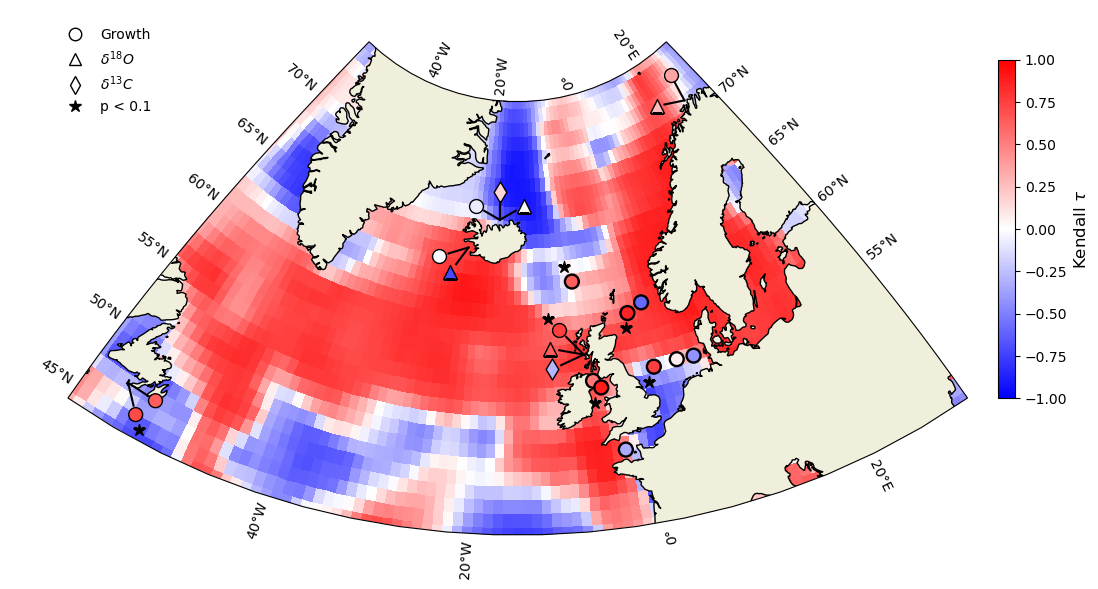

In [18]:
plt.close()
plot_ar1_biv_na(en4_ews_na,coords,title='',
                namefig='EN4_biv_SNA_0-100mtemp_ar1',shrink_bar=0.4)
plt.show()